In [1]:
%matplotlib widget


import meshplot as mp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import torch
import pandas as pd
from numba import jit

In [2]:
### Parameters ###

from numba import types
from numba.typed import Dict

def MakeDictFloat():
    d=Dict.empty(
    key_type=types.unicode_type,
    value_type=types.float64,)
    return d

def setpars():
    pars=MakeDictFloat()
    pars['thetaR']=0.075
    pars['thetaS']=0.287
    pars['alpha']=1.611e6
    pars['beta']=3.96
    pars['A']=1.175e6
    pars['gamma']=4.74
    pars['Ks']=0.00944
    return pars

In [3]:
### Solver ###


#@jit(nopython=True)
def Cfun(psi,pars):
    x3=(pars['alpha']+torch.abs(psi)**pars['beta'])**2.
    x2=pars['alpha']/x3
    x1=pars['beta']*torch.abs(psi)**(pars['beta']-1)*x2
    C=(pars['thetaS']-pars['thetaR'])*x1
    return C

#@jit(nopython=True)
def Kfun(psi,pars):
    x2=pars['A']+torch.abs(psi)**pars['gamma']
    x1=pars['A']/x2
    K=pars['Ks']*x1
    return K

#@jit(nopython=True)
def thetafun(psi,pars):
    x3=pars['alpha']+torch.abs(psi)**pars['beta']
    x2=pars['alpha']/x3
    x1=(pars['thetaS']-pars['thetaR'])*x2
    theta=pars['thetaR']+x1
    return theta


#@jit(nopython=True)
def solverfun(R,C,Kmid,dt,dz,n):
    a=torch.zeros(n)
    b=torch.zeros(n)
    c=torch.zeros(n)
    y=torch.zeros(n)

    #Kmid = (K[1:]+K[:-1])/2.

    a=Kmid[:-1]/dz
    b=-(Kmid[:-1]+Kmid[1:])/dz-C*dz/dt
    c=Kmid[1:]/dz
    A=torch.diag(a[1:],-1)+torch.diag(b,0)+torch.diag(c[:-1],1)
    #print(A)

    y[:] = R[:]

    dell = torch.linalg.solve(A, y)


    return dell

#@jit(nopython=True)
def Rfun(psiiter,psiin,psiT,psiB,C,Kmid,dtheta,dt,dz,n):
    # This solves the Picard residual term:
    psigrid=torch.hstack((psiB,psiiter,psiT))
    
    x1=dtheta/dt*dz
    x2=-(Kmid[1:]-Kmid[:-1])
    x3=-Kmid[1:]*(psigrid[2:]-psigrid[1:-1])/dz
    x4=Kmid[:-1]*(psigrid[1:-1]-psigrid[:-2])/dz

    R=x1+x2+x3+x4

    return R

#@jit(nopython=True)
def iterfun(psiin,pars,psiT,psiB,dt,dz,n):
    # psiin = psi^n
    # psiiter = psi^n+1,m
    # psiout = psi^n+1,m+1

    tolerance=1e-10
    maxcount=1000
    Rmax=1.

    # Initialize arrays
    psiiter=torch.zeros(len(psiin))
    psiout=torch.zeros(len(psiin))

    # Initial guess: psi_n+1^1 = psi_n
    psiiter[:]=psiin[:]

    count=0.
    while count <= 1 or (Rmax >= tolerance and count<= maxcount):
        # Get C,K:
        C=Cfun(psiiter,pars)
        K=Kfun(torch.hstack((psiB, psiiter, psiT)),pars)
        Kmid=(K[1:]+K[:-1])/2.
        dtheta=thetafun(psiiter,pars)-thetafun(psiin,pars)
        # Get R
        R=Rfun(psiiter,psiin,psiT,psiB,C,Kmid,dtheta,dt,dz,n)
        # Solve for del
        dell=solverfun(R,C,Kmid,dt,dz,n)
        # Update psi estimates at different iteration levels
        psiout[:]=psiiter[:]+dell[:]
        
        psiiter[:]=psiout[:]
        Rmax=torch.abs(torch.max(R))
        count+=1

    #print('Iteration count = %d'%(count-1))

    return psiout


#@jit(nopython=True)
def massbal(psi,psiT,psiB,pars,n,dt,dz):

    # Initial storage:
    theta=thetafun(psi.reshape(-1),pars)
    theta=torch.reshape(theta,psi.shape)
    S=torch.sum(theta*dz,1)
    S0=S[0]
    SN=S[-1]

    # Inflow:
    Kin=(Kfun(psiB,pars)+Kfun(psi[:,0],pars))/2.
    QIN=-Kin*((psi[:,0]-psiB)/dz+1.)
    QIN[0]=0.
    QINsum=torch.sum(QIN)*dt

    # Outflow:
    Kout=(Kfun(psi[:,-1],pars)+Kfun(psiT,pars))/2.
    QOUT=-Kout*((psiT-psi[:,-1])/dz+1.)
    QOUT[0]=0.
    QOUTsum=torch.sum(QOUT)*dt

    # Balance:
    dS=SN-S0
    dQ=QINsum-QOUTsum
    err=dS/dQ
    
    #return QIN,QOUT,S,err
    return err

#@jit(nopython=True)
def ModelRun(dt,dz,n,nt,psi,psiB,psiT,pars):
    # Solve:
    for j in range(1,nt):
        psi[j,:]=iterfun(psi[j-1,:],pars,psiT,psiB,dt,dz,n)

    err=massbal(psi,psiT,psiB,pars,n,dt,dz)

    return psi,err


In [4]:
### Set parameters ###

def setup(dt):
    # Set parameters:
    pars=setpars()

    # Grid:
    zN=40.
    dz=1.
    tN=360.

    z=torch.arange(dz,zN,dz)
    n=len(z)

    t=torch.arange(0,tN+dt,dt)
    nt=len(t)

    # Initialize array:
    psi=torch.zeros((nt,n))

    # ICs:
    psi[0,:]=-61.5

    # BCs:
    psiB=torch.tensor([-61.5])
    psiT=torch.tensor([-20.7])

    return z,t,dz,n,nt,zN,psi,psiB,psiT,pars





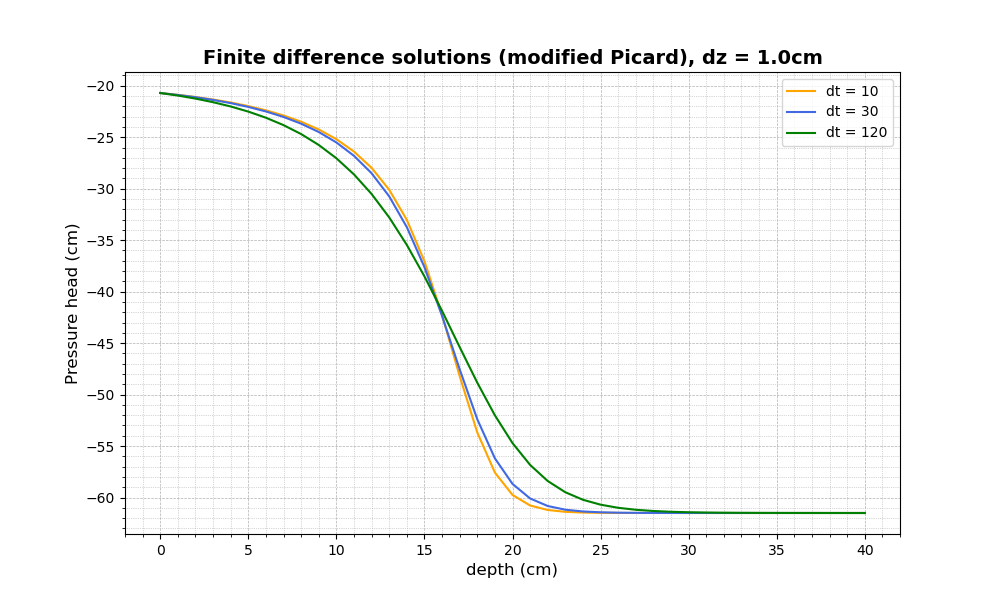

In [13]:
### Plotting test ###

dts = [10,30,120]

plt.figure(figsize=(10, 6))
colors = ['orange','royalblue','green']

for i in range(len(dts)):
    z,t,dz,n,nt,zN,psi,psiB,psiT,pars=setup(dts[i])
    psi,err = ModelRun(dts[i],dz,n,nt,psi,psiB,psiT,pars)
    psifinal=torch.hstack([psiB,psi[-1,:],psiT])
    z=np.hstack([0,z,zN])
    z=z[-1]-z
    plt.plot(z, psifinal.detach().numpy(),label= f"dt = {dts[i]}",color=colors[i])


plt.legend(title='')
plt.title("Finite difference solutions (modified Picard), dz = 1.0cm", fontsize=14, fontweight='bold')
plt.grid(True)
plt.xlabel("depth (cm)", fontsize=12)
plt.ylabel("Pressure head (cm)", fontsize=12)


plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.grid(True, which='minor', linestyle=':', linewidth=0.5)

plt.show()


In [14]:

dt = 120


z,t,dz,n,nt,zN,psi,psiB,psiT,pars=setup(dt)
psi,err = ModelRun(dts[i],dz,n,nt,psi,psiB,psiT,pars)


psi

tensor([[-61.5000, -61.5000, -61.5000, -61.5000, -61.5000, -61.5000, -61.5000,
         -61.5000, -61.5000, -61.5000, -61.5000, -61.5000, -61.5000, -61.5000,
         -61.5000, -61.5000, -61.5000, -61.5000, -61.5000, -61.5000, -61.5000,
         -61.5000, -61.5000, -61.5000, -61.5000, -61.5000, -61.5000, -61.5000,
         -61.5000, -61.5000, -61.5000, -61.5000, -61.5000, -61.5000, -61.5000,
         -61.5000, -61.5000, -61.5000, -61.5000],
        [-61.5000, -61.5000, -61.5000, -61.5000, -61.5000, -61.4999, -61.4999,
         -61.4998, -61.4996, -61.4993, -61.4989, -61.4981, -61.4968, -61.4946,
         -61.4909, -61.4847, -61.4742, -61.4565, -61.4267, -61.3767, -61.2929,
         -61.1527, -60.9201, -60.5377, -59.9196, -58.9460, -57.4717, -55.3605,
         -52.5504, -49.1167, -45.2781, -41.3248, -37.5216, -34.0455, -30.9749,
         -28.3116, -26.0130, -24.0186, -22.2663],
        [-61.4999, -61.4999, -61.4997, -61.4995, -61.4992, -61.4987, -61.4979,
         -61.4965, -61.4943, -6